# IMPORT LIBRARIES

This notebook requires the following libraries:

In [22]:
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import interpn
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib2 import Path
import os
import pickle

In [2]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,scipy,matplotlib,seaborn,pathlib2 -a Silvia_Lazzardi -g -r -b -w

Silvia_Lazzardi 
last updated: Mon Mar 30 2020 

CPython 3.7.4
IPython 7.8.0

pandas 0.25.1
numpy 1.17.2
scipy 1.3.1
matplotlib 3.1.1
seaborn 0.9.0
pathlib2 2.3.5

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 
Git repo   : 
Git branch : 
watermark 2.0.2


# DOWNLOAD AND PREPARE DATA

## Define Paths

In [ ]:
# Specify here your own paths here
path_all_data=Path('')
path_csv = Path('')
path_csv_mca = Path('')
path_data_counts = Path('')
path_data_mca = Path('')
path_sampling_model = Path('')

In [ ]:
path_all_data=Path('data_all.pkl')
path_data_counts = Path('./counts')
path_data_mca=Path('Bone_Marrow.npy')
path_sampling_model = Path('Bone_Marrow_sampling.npy')

Please, download data from the Tabula Muris consorzium:

https://ndownloader.figshare.com/articles/5715040/versions/1 

Un-zip the folder and put the csv files in 'path_csv'.

The folder contains gene-count tables for FACS sorted cells sequenced with Smart-Seq2 from 20 organs of 7 mice. Cells are grouped by tissue of origin. It Includes data for 53,760 cells, 44,879 of which passed a QC cutoff of at least 500 genes and 50,000 reads. 

This is the list of files currently present in the Tabula Muris FACS database:

In [4]:
organ_list=os.listdir(path_counts)

In [11]:
tm=[organ.split('.')[0] for organ in organ_list]

To get ready for the analysis, let's prepare the data sets by leaving out the cells which do not passed the QC control defined above.

This operation takes long time...

In [ ]:
def save_count_matrices(path_csv,path_data_counts, organ_name):
    path_save = path_data_counts/'{}.npy'.format(organ_name)
    organ='{}-counts.csv'.format(('_').join(organ_name.split(' ')))
    df=pd.read_csv(str(path_csv/organ), header=0) 
    counts=np.array(df)[:,1:]
    sizes=np.sum(counts,axis=0)
    genes_for_cell = np.array([(np.argwhere(counts[:,j]>0)).shape[0] for j in range(counts.shape[1])])
    cells_to_drop1 = np.concatenate(np.argwhere(sizes<50000))
    cells_to_drop2 = np.concatenate(np.argwhere(genes_for_cell<500))
    cells_to_drop= np.unique(np.concatenate((cells_to_drop1, cells_to_drop2)))
    idx=np.delete(np.arange(0,counts.shape[1]),cells_to_drop)
    counts=counts[:,idx]
    np.save(str(path_save),counts)

In [ ]:
for organ_name in tm:
    save_count_matrices(path_csv,path_data_counts, organ_name)

# SET PARAMETERS FOR THE PLOTS

In [6]:
sns.set_style("ticks")
fontsize_written=35
fontsize_ticks=35
lw=15
ms=25
s_size=(18,15)

In [7]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20b")
colors= np.concatenate((cmap1(np.arange(20)), cmap2(np.arange(20))))

# Organs Color Legend

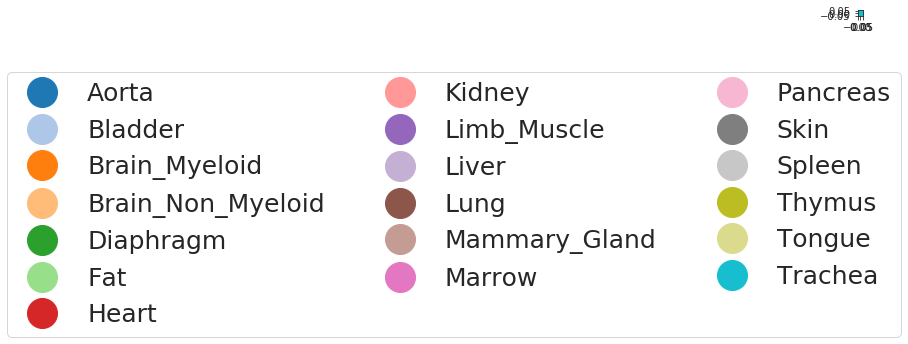

In [12]:
fig,ax=plt.subplots(figsize=(0.1,0.1))
for idx,i in enumerate(tm):
    plt.plot(0, 0, 'o',lw=8,color=colors[idx], label=i)
lgd = plt.legend(ncol=3, bbox_to_anchor=(10, -8), fontsize=25, frameon=True, 
                 markerscale=5, fancybox=True)
plt.show()

# The single-cell Transcriptome as a Component System

## Statistical laws in single-cell RNA sequencing data

# FIGURE 1
## Rank plots

Below it's reported the code used to realize the plots in panel (B) and (D) of Figure 1. Panel (B) is the rank plot for all the organs of tabula muris FACS data sets, while panel (D) is the rank plot of the 100 more sequenced cells of the organ 'Heart'. If needed, you can use any data set organ.

In [13]:
def rank_plots_1B(path_data_counts, fontsize_written, fontsize_ticks, lw, size=s_size):
    def func(x, a,b):
        return b/(x**a)
    fig,ax=plt.subplots(figsize=size)
    for i,organ in enumerate(os.listdir(path_data_counts)):
        path_data_=path_data_counts/organ
        organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
        genes_num=organ_counts.shape[0]
        mge=np.mean(organ_counts,axis=1)
        mge_=mge/np.sum(mge, axis=0)
        ax.plot(np.sort(mge_)[::-1], lw=lw, color=colors[i], alpha=0.7)
    x=np.linspace(1,genes_num, num=genes_num+1)
    ax.plot(x, func(x,0.8,0.1),'--', lw=20, color='gray')
    plt.annotate("$k*i^{-0.8}$",xy=(10000,0.1) ,xytext=(100,0.01), fontsize=fontsize_written, color='black')  
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank, $i$', fontsize=fontsize_written)
    plt.ylabel('Frequency, $f_i$', fontsize=fontsize_written)
    plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
    plt.show() 

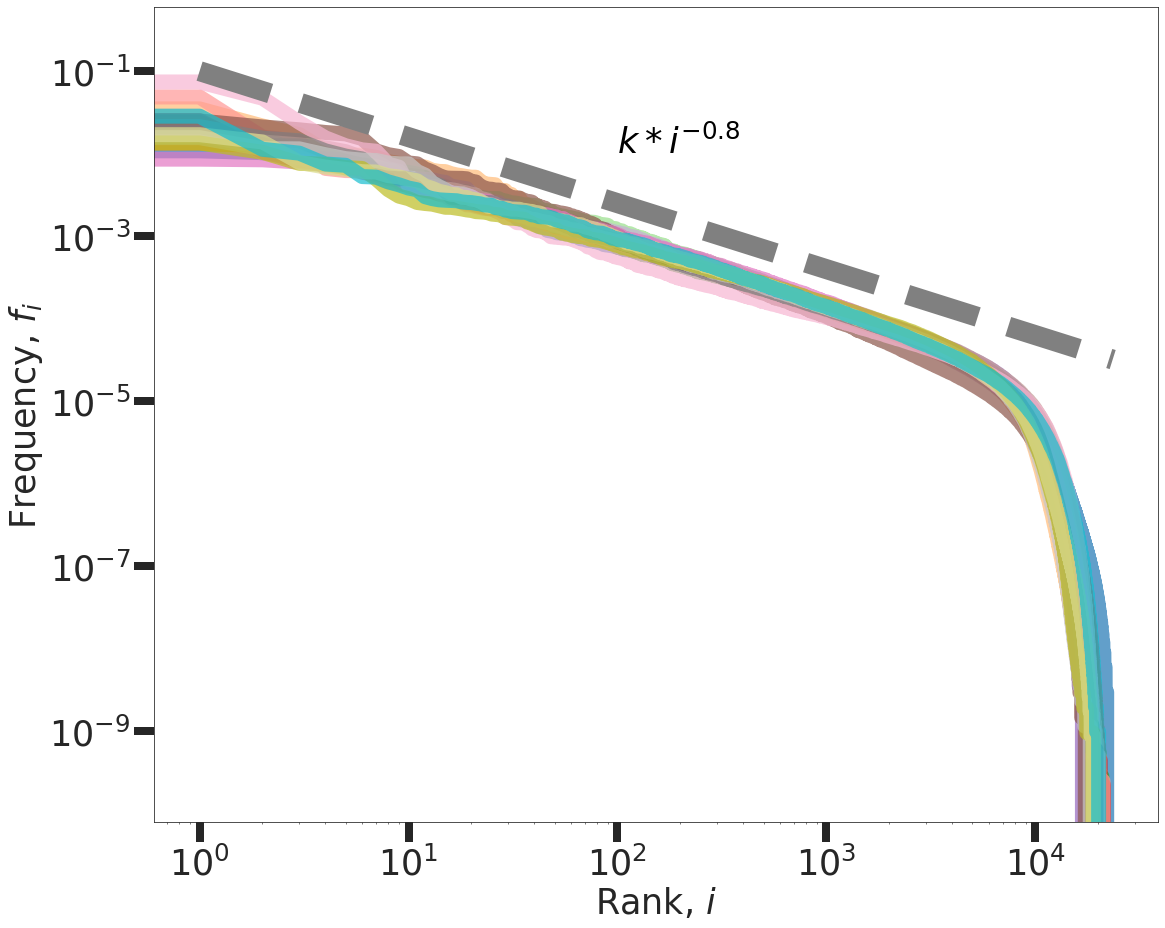

In [14]:
rank_plots_1B(path_data_counts, fontsize_written, fontsize_ticks, lw, size=s_size)   

In [15]:
def rank_plots_1D(path_data_counts, organ_name, fontsize_written, fontsize_ticks, size=s_size):
    def func(x, a,b):
        return b/(x**a)
    fig,ax=plt.subplots(figsize=size)
    organ='{}.npy'.format(organ_name)
    path_data_=path_data_counts/organ
    organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
    genes_num=organ_counts.shape[0]
    not_zeros_cells=[(np.argwhere(organ_counts[:,j]>0)).shape[0] for j in range(organ_counts.shape[1])]
    idx_sort=np.argsort(not_zeros_cells)[::-1][:100]
    for idx in idx_sort:
        cell = organ_counts[:,idx]
        cell_ = np.sort(cell)[::-1]/np.sum(cell)
        plt.plot(cell_,'-',lw=3)
    x=np.linspace(1,genes_num, num=genes_num+1)
    ax.plot(x, func(x,0.8,0.1),'--', lw=20, color='gray')
    plt.annotate("$k*i^{-0.8}$",xy=(10000,0.1) ,xytext=(100,0.01), fontsize=fontsize_written, color='black')  
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank, $i$', fontsize=fontsize_written)
    plt.ylabel('Frequency, $f_i$', fontsize=fontsize_written)
    plt.tick_params(labelsize=fontsize_ticks, width=8, length=20)
    plt.show()

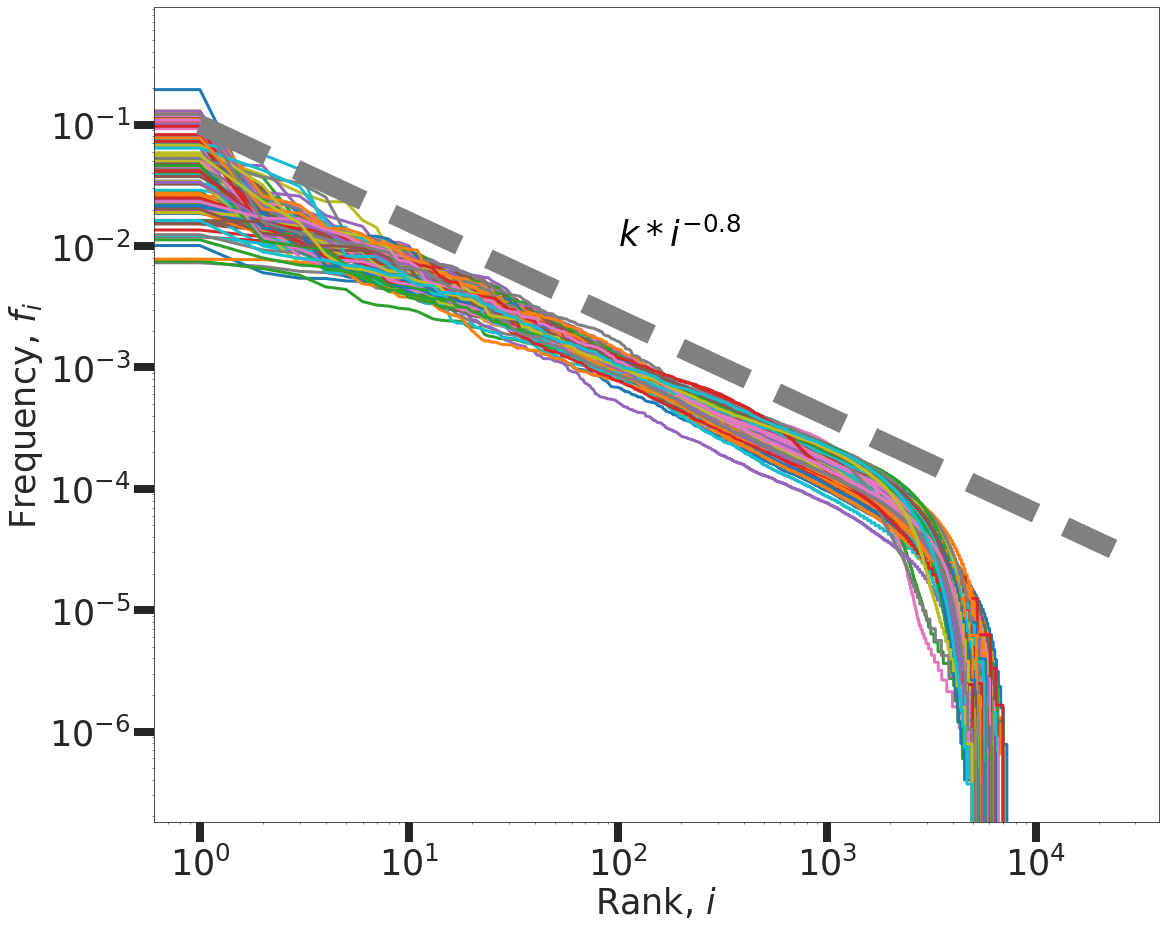

In [16]:
rank_plots_1D(path_data_counts, 'Heart', fontsize_written, fontsize_ticks,size=s_size)

# FIGURE 6 
## $CV^2$ vs. mean gene expression

Below the code to realize panel B of Figure 5. Or rather, the scatterplot of $CV^2$, defined as:

$CV^2=\sigma^2/mg^2$

in function of the mean gene expression $mg$.

We need the mean gene expression calculated over all the cells in the data sets and the correpondent values for $CV^2$. This informations,based on the data set version *** are reported in the file "data_all.pkl". 

If the data set had undergone changes from the version considered here, please use the same functions applied to the current data set.

In [18]:
with open(str(path_all_data/"data_all.pkl"),"rb") as file:
    data = pickle.load(file)
means = data['means']
var = data['var']
cv2 = data['cv2']

We want to use just the genes which have enough statistics, so we considered that ones with at least a total number of counts equal to the $98\%$ of cells number. You can choose a different bound.

In [ ]:
genes_on=np.zeros(23432)
lim=55*10**3*0.98
for organ in os.listdir(path_data_counts):
    path_data_=path_data_counts/organ
    organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
    genes_on_organ=np.sum(organ_counts,axis=1)
    genes_on = genes_on + genes_on_organ
genes_good = np.concatenate(np.argwhere(genes_on>lim))

In [19]:
def scatterdense(x, y, ax=None, nbins=80, colorbar=True, c_title="density", **kwargs):
    xmin = np.log10(min(x[x>0]))
    xmax = np.log10(max(x))
    ymin = np.log10(min(y[y>0]))
    ymax = np.log10(max(y))

    xbins = np.logspace(xmin, xmax, nbins) # <- make a range from 10**xmin to 10**xmax
    ybins = np.logspace(ymin, ymax, nbins) # <- make a range from 10**ymin to 10**ymax
    data , x_e, y_e = np.histogram2d(x, y, bins = (xbins, ybins))
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    if ax is None:
        fig=plt.figure()
        ax=fig.subplots()
    ax.scatter(x, y, c=z, s=225, alpha=0.5, cmap="viridis", **kwargs)
    if colorbar:
        from matplotlib import cm
        import matplotlib
        cbar = ax.get_figure().colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=1, vmax=max(z)), cmap="viridis"), ax=ax)
        cbar.ax.set_ylabel(c_title, fontsize=20)
        cbar.ax.tick_params(labelsize=20)

In [23]:
def plotcv2mean(means, variances, ax=None, normalisation_str = "counts", poisson_limit=1, colorbar=True, **kwargs):
    if ax is None:
        fig=plt.figure(figsize=(18,15))
        ax=fig.subplots()
    x_lin = np.logspace(np.log10(np.nanmin(means)),np.log10(np.nanmax(means)), dtype=float,num=50)
    cv2 = np.array([variances[i]/(np.power(mean,2)) for i,mean in enumerate(means) if mean>0])
    scatterdense(means[means>0], cv2,ax=ax, label="data", colorbar=colorbar, c_title="Number of genes", **kwargs)   
    sort_pos=np.sort(means[np.argwhere(means>0)])
    k = np.argwhere(sort_pos>10)[0]
    t=np.linspace(0,10**4,num=1000)
    t2=np.linspace(1,10**4,num=1000)
    p=np.linspace(10**(-5),1,num=1000)
    bound=60000 -1 
    ax.plot(t,np.repeat(bound,1000),'--',lw=15, color='orange',label='R-1')
    ax.plot(p,1/p,'--',lw=15, color='red',label='$m_g^{-1}}$ (Poisson)')
    ax.plot(t2,np.repeat(1,1000),'--',lw=15, color='blue',label='1 (Taylor)')
    
    ax.tick_params(labelsize=35, width=5, length=10, which="minor")
    
    ax.set_ylabel("Coefficient of variation squared, $CV^2_g$", fontsize=35)
    ax.set_xlabel("Mean expression level, $m_g$", fontsize=35)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(means[means>0].min()*0.9,np.power(10,np.log10(np.nanmax(means))+1))
    ax.legend(fontsize=24)
    plt.show()

/home/silvia/anaconda3-new/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/silvia/anaconda3-new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


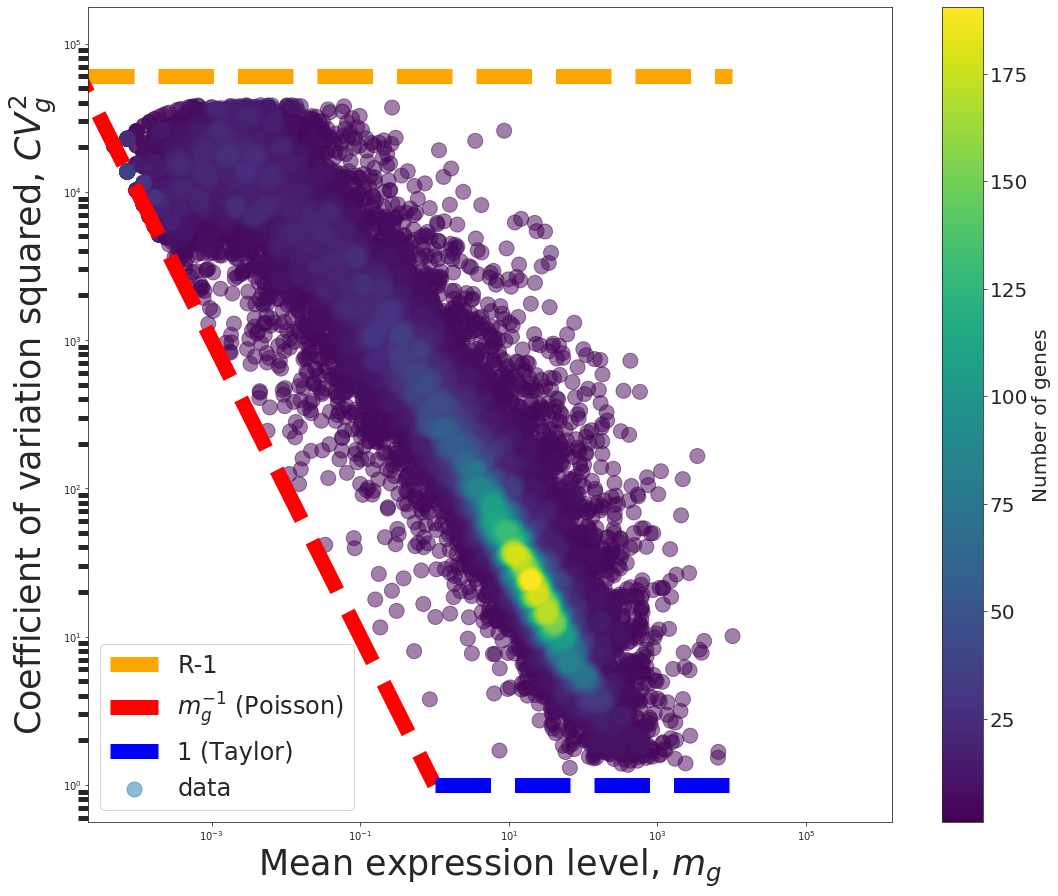

In [24]:
#means_,var_ = means[genes_good], var[genes_good]
plotcv2mean(means, var, ax=None, normalisation_str = "counts", poisson_limit=1, colorbar=True)

# Probability density function to count a gene in N cells

It represent the Probability that a gene is turned-on in n cells, compared with the Sampling Model.

## Sampling Model

In [ ]:
def sampling_model_organ(path_data_counts, organ_name, path_sampling):
    rs = np.random.RandomState(seed=42)
    path_data_= path_data_counts/'{}.npy'.format(organ_name)
    path_save=path_sampling/'{}.npy'.format(organ_name)
    organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
    mean=np.mean(organ_counts, axis=1)
    n_genes=organ_counts.shape[0]
    n_cells=organ_counts.shape[1]
    fake_organ=np.zeros((organ_counts.shape)).astype('float32')
    pdf= mean/(np.sum(mean, axis=0)+10**4)
    for i in range(n_cells):
        fake_col=np.mean(np.random.multinomial(int(np.sum(organ_counts,axis=0)[i]), pdf, size=5),axis=0)               
        fake_organ[:,i]= np.array(fake_col)
        fake_organ= fake_organ.reshape((n_genes,n_cells))
        np.save(str(path_save),fake_organ)

Using the previous function we produce a random sampling fake-organ which genes respect the same rank plot of the original one. We used as example Bone Marrow but you can do the same with any organ by changing the parameter 'organ_name'

In [ ]:
sampling_model_organ(path_data_counts, 'Marrow', path_sampling_model)

In [25]:
organ='Bone_Marrow.npy'
path_data_=path_data_counts/organ
path_sampling_organ=path_sampling_model/organ
            
organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
sampling=np.load(str(path_sampling_organ), allow_pickle=True).astype('float32')

cells_num=sampling.shape[1]

U_counts = [np.argwhere(organ_counts[i,:]>0).shape[0] for i in range(organ_counts.shape[0])]
U_counts=np.array(U_counts)/cells_num

U_sampling = [np.argwhere(sampling[i,:]>0).shape[0] for i in range(sampling.shape[0])]
U_sampling =np.array(U_sampling)/cells_num

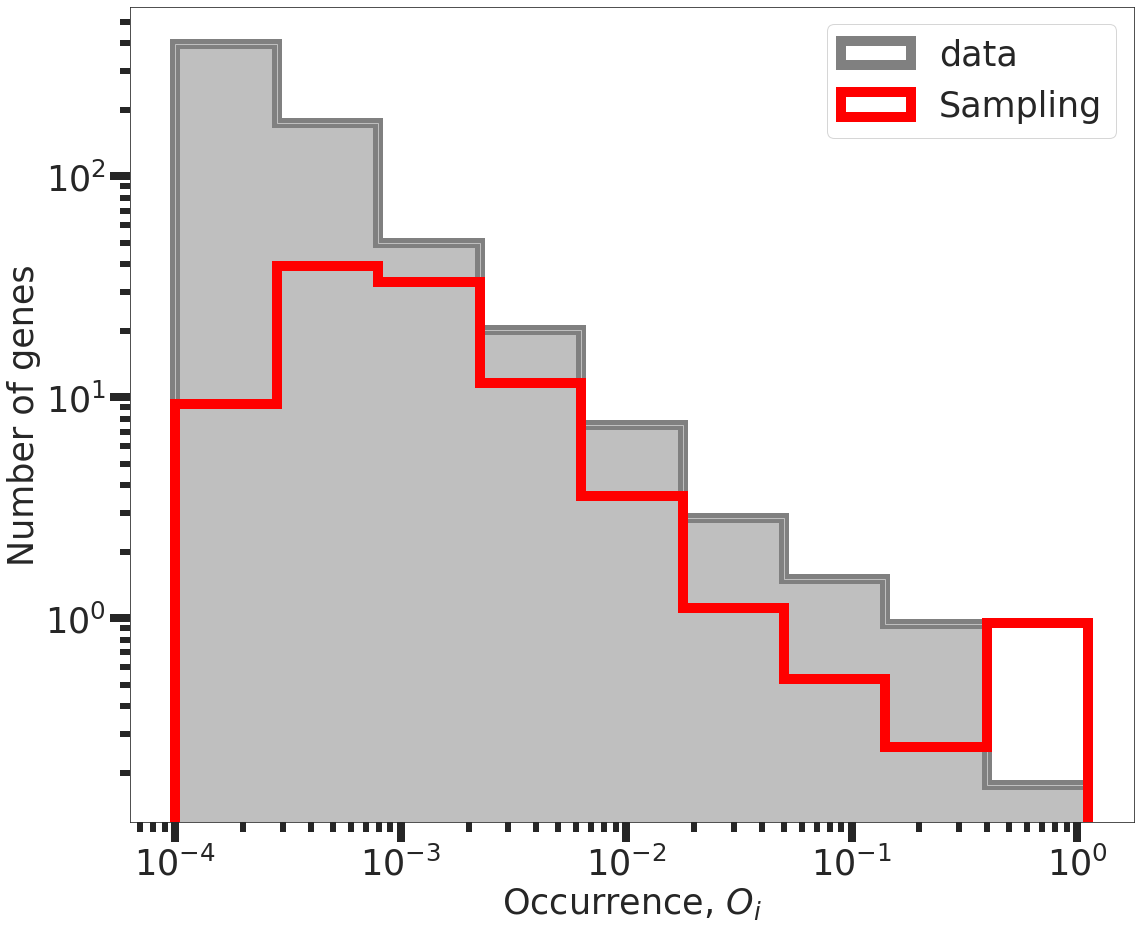

In [26]:
fig,ax=plt.subplots(figsize=s_size)
r=np.linspace(-4,0.05,10)
binsx=[10**i for i in r]
plt.hist(U_counts, histtype='step',density=True,  bins=binsx, lw=10, color='gray', label='data')
plt.hist(U_counts, histtype='stepfilled', density=True, alpha=0.5, bins=binsx, color='gray')
plt.hist(U_sampling, histtype='step',density=True,bins=binsx, lw=10, color='red', label='Sampling')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right', fontsize=fontsize_written)
plt.xlabel("Occurrence, $O_i$",fontsize=fontsize_written)
plt.ylabel('Number of genes',fontsize=fontsize_written)
plt.tick_params(labelsize=fontsize_ticks, length=20, width=8)
plt.tick_params(axis='both',which='minor', bottom=True,width=6,length=10, labelsize=18)

# SUPPLEMENTARY MATERIALS

# FIGURE S1
## Rank Plot of 100 "Bone Marrow" cells  (Mouse Cell Atlas data set)

The first plot of the Supplementary material is the rank plot of the 100 more sequenced cells of the organ 'Bone Marrow' from the data set "Mouse Cell Atlas". You can download data from:

https://ndownloader.figshare.com/articles/5435866/versions/8

Put the organ you want to analyze in the path defined as: path_csv_mca.

Then, you can apply the following function to get the data ready for the analysis:

In [ ]:
save_count_matrices(path_csv_mca,path_data_mca, organ_name)

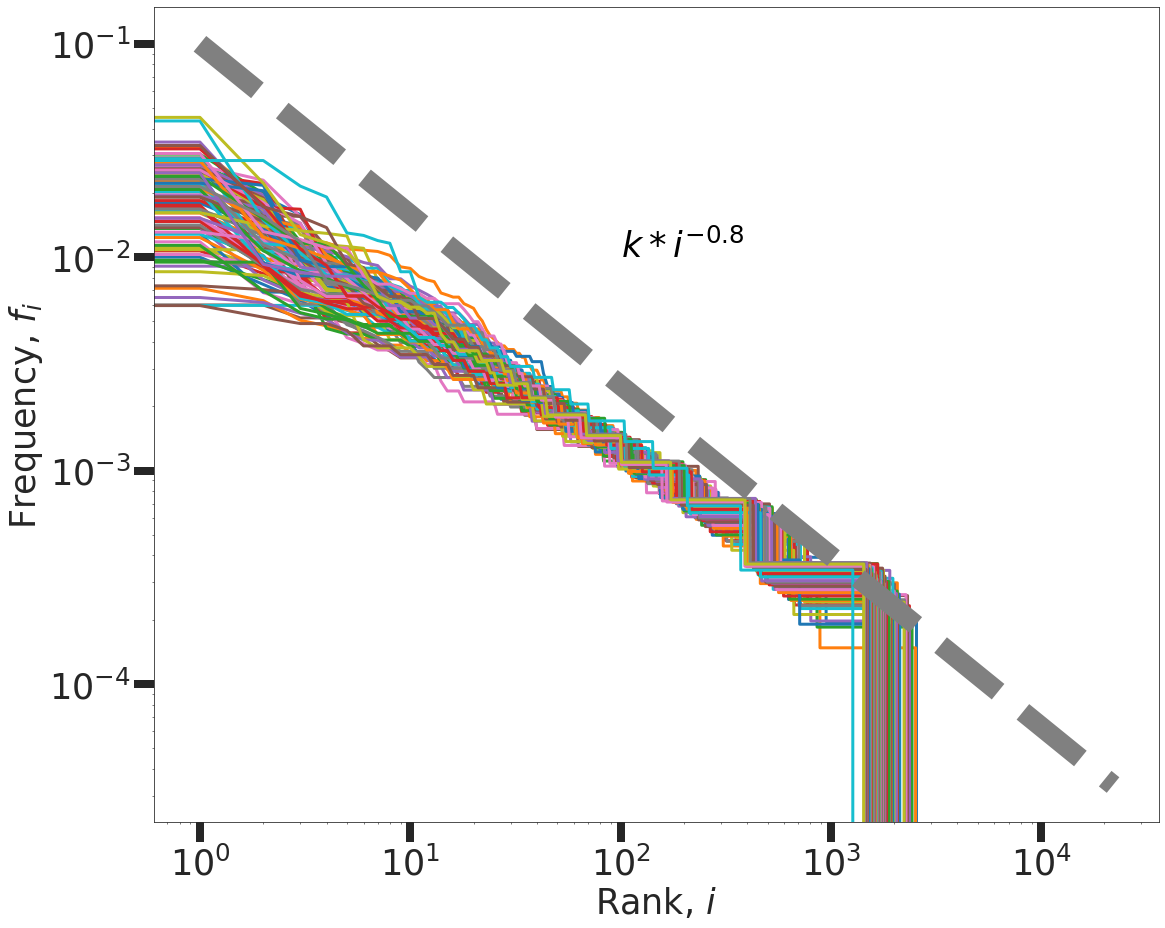

In [28]:
rank_plots_1D(path_data_mca,'Bone_Marrow', fontsize_written, fontsize_ticks,size=s_size)

# Tabula Muris Size distribution

In [34]:
M=[]
for i,organ in enumerate(os.listdir(path_data_counts)):
    path_data_=path_data_counts/organ
    organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
    M_o=np.sum(organ_counts,axis=0)
    M.append(list(M_o))
M = np.array(M)

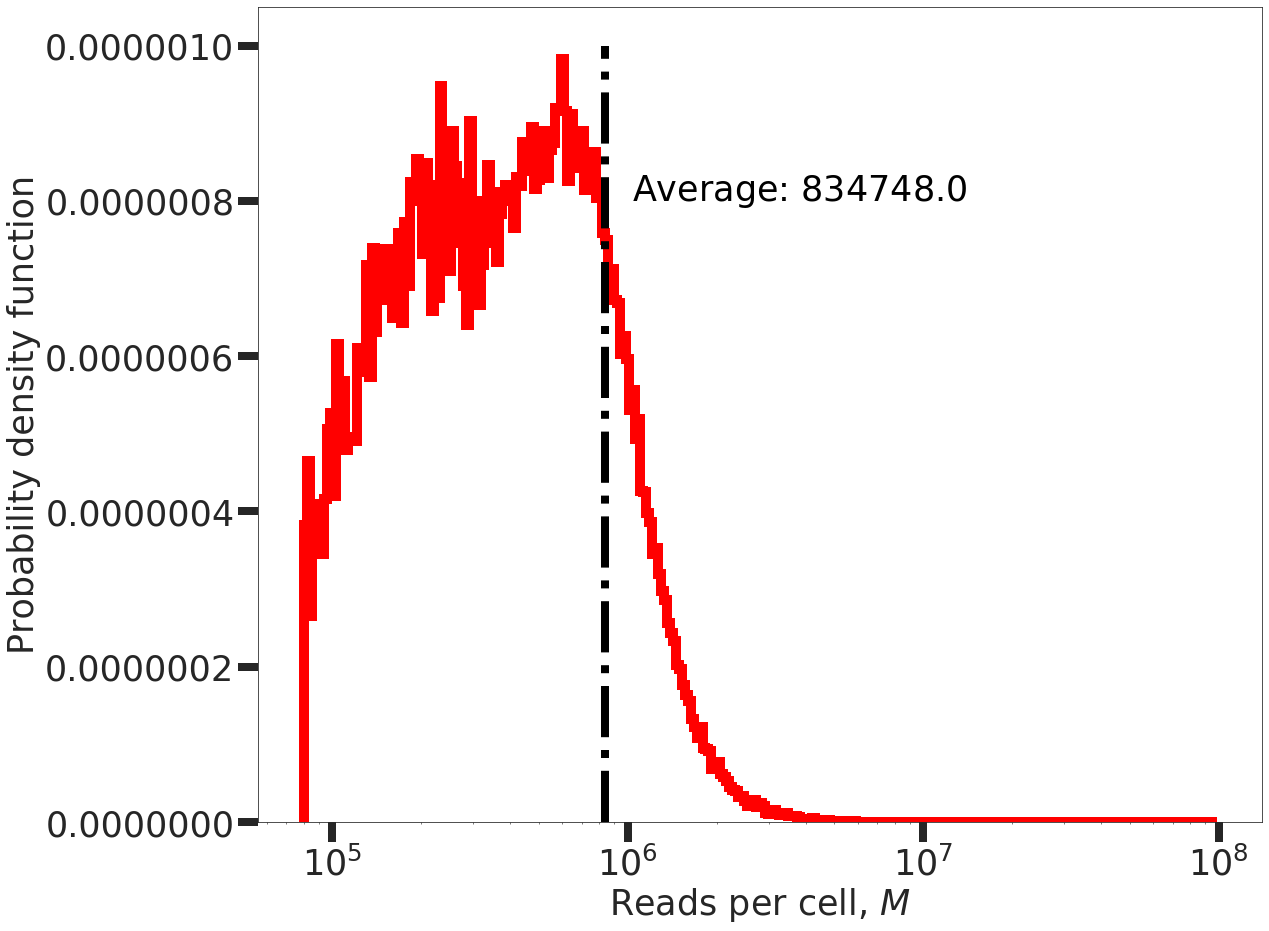

In [35]:
M_=[]
for i in range(M.shape[0]):
    M_.append(np.array(M[i]))
M_=np.array(M_)
M_= np.concatenate(M_)
avg=np.mean(M_)
mediana=np.median(M_)
fig=plt.figure(figsize=(18,15))
a = np.arange(start=np.log10(0.8*100000),stop=8, step=0.01)
xbins=[10**i for i in a]
plt.hist(M_, bins=xbins, histtype='step', lw=10, density=True, color='r' )
plt.plot(np.repeat(avg,1000),np.linspace(0,0.000001,num=1000), '-.', lw=8, color='black')
plt.annotate("Average: ${}$".format(np.round_(avg,decimals=0)),xy=(avg+200000,0.0000008) ,xytext=(avg+200000,0.0000008), fontsize=fontsize_written, color='black')  
plt.xscale('log')
plt.xlabel('Reads per cell, $M$', fontsize=fontsize_written)
plt.ylabel('Probability density function',fontsize=fontsize_written)
plt.tick_params(labelsize=fontsize_ticks,  width=8, length=20)

# Fraction of Trancriptome described

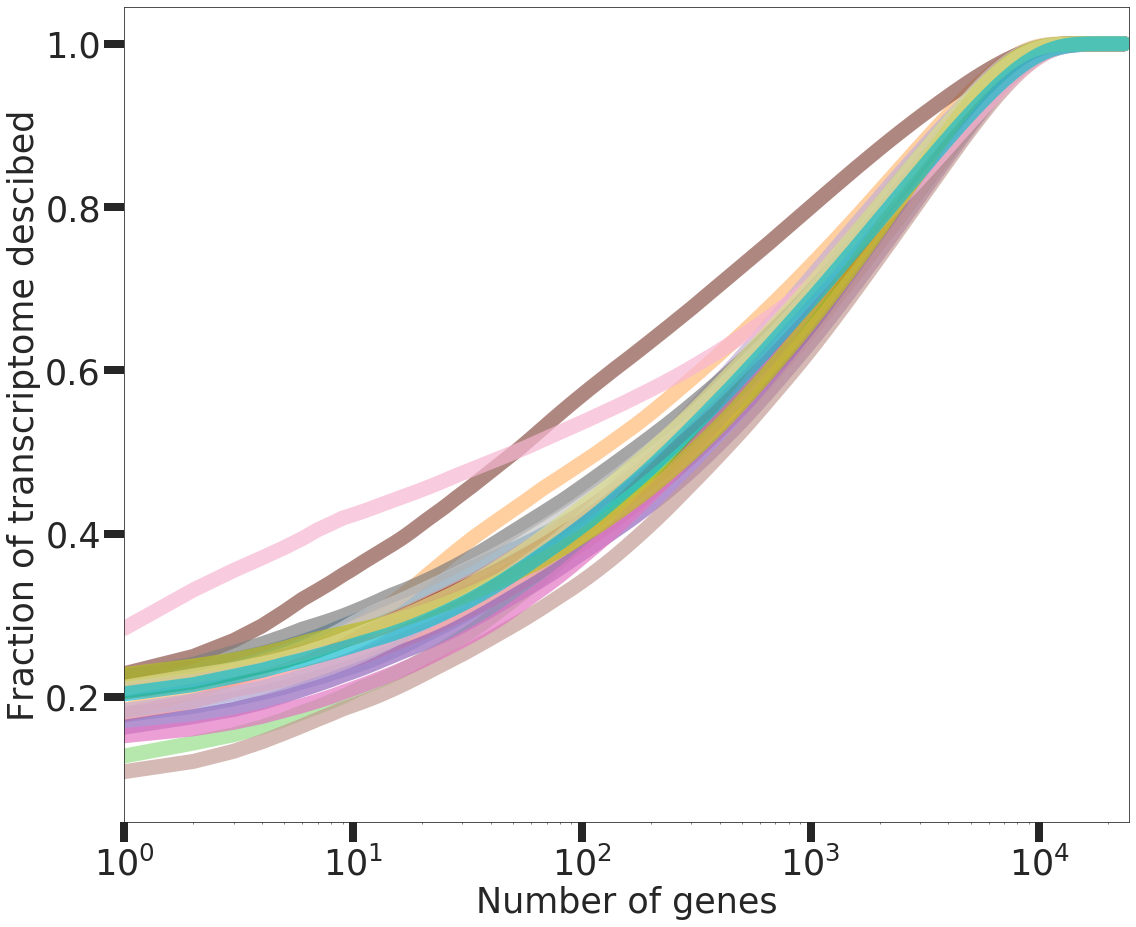

In [36]:
def transcriptome_rank_counts(path_data_counts, fontsize_written, fontsize_ticks, size):
    fig,ax=plt.subplots(figsize=size)
    for i,organ in enumerate(os.listdir(path_data_counts)):
        path_data_=path_data_counts/organ
        organ_counts=np.load(str(path_data_), allow_pickle=True).astype('float32')
        size=np.sum(organ_counts,axis=0)
        F=np.sum(size)
        transc=organ_counts/np.float(F)
        n_cells=transc.shape[1]
        mean_genes = np.mean(transc, axis=1)
        mean_genes = mean_genes/np.sum(mean_genes)
        mean_cells = np.mean(transc, axis=0)
        cumsum_mean=np.cumsum((np.sort(mean_genes)[::-1]))
        ax.plot(cumsum_mean, '-', color=colors[i], lw=15, alpha=0.7)
        plt.xlim(left=1)
        plt.xscale('log')
        plt.ylabel('Fraction of transcriptome descibed', fontsize=fontsize_written)
        plt.xlabel('Number of genes', fontsize=fontsize_written)  
        plt.tick_params(labelsize=fontsize_ticks, length=20, width=8)
    plt.show()
transcriptome_rank_counts(path_data_counts,fontsize_written, fontsize_ticks, size=s_size)